ERA5 hourly data on pressure levels from 1940 to present

Product type

Reanalysis

Variable

Divergence, Fraction of cloud cover, Geopotential, Ozone mass mixing ratio, Potential vorticity, Relative humidity, Specific cloud ice water content, Specific cloud liquid water content, Specific humidity, Specific rain water content, Specific snow water content, Temperature, U-component of wind, V-component of wind, Vertical velocity, Vorticity (relative)

Year

2020

Month

June, July, August

Day

01, 02, 03, 04, 05, 06, 07, 08, 09, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31

Time

00:00, 06:00, 12:00, 18:00

Pressure level

500 hPa

Geographical area

North: 60°, West: 110°, South: 10°, East: 180°

Data format

NetCDF4 (Experimental)

Download format

Zip

In [3]:
import xarray as xr
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from torch.utils.data import Dataset, DataLoader
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import torch


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = "yourpath/data_stream-oper_stepType-instant.nc"

ds = xr.open_dataset(file_path)

In [6]:
variables = ['z','t','u','v', 'q']
level = 0
time_window = 40
target_variable = 'z'
selected_year = 2020

ds_year = ds.sel(valid_time=ds.valid_time.where(ds.valid_time.dt.year == selected_year, drop=True))

T_total = len(ds_year.valid_time)
H = len(ds_year.latitude)
W = len(ds_year.longitude)
C = len(variables)

print(f"Total time steps: {T_total}, Height: {H}, Width: {W}, Channels: {C}")

Total time steps: 368, Height: 201, Width: 281, Channels: 5


In [ ]:
batch_size = 100

sample_indices = list(range(time_window, T_total))
print(f"총 선택된 샘플 수: {len(sample_indices)}")

X_batch = []
y_batch = []
valid_time_batch = []

file_path = 'yourpath'
os.makedirs(file_path, exist_ok=True)

existing_files = sorted([f for f in os.listdir(file_path) if f.startswith('X_part')])
if existing_files:
    last_file = existing_files[-1]
    last_part_num = int(last_file.split('X_part')[-1].split('.npy')[0])
    X_batch = list(np.load(os.path.join(file_path, f'X_part{last_part_num}.npy')))
    y_batch = list(np.load(os.path.join(file_path, f'y_part{last_part_num}.npy')))
    valid_time_batch = list(np.load(os.path.join(file_path, f'valid_times_part{last_part_num}.npy')))
    start_idx = time_window + last_part_num * batch_size
    sample_indices = sample_indices[last_part_num * batch_size:] if last_part_num * batch_size < len(sample_indices) else []
    print(f"이어서 처리 시작: 인덱스 {start_idx}")
    part_num = last_part_num
else:
    part_num = 0


총 선택된 샘플 수: 328
이어서 처리 시작: 인덱스 440


In [ ]:
import numpy as np

x_path = 'yourpath/X_full_(z,t,u,v,q).npy'
x = np.load(x_path)
print(x.shape)  # (328, T, C, H, W)

(328, 40, 5, 201, 281)


In [9]:
import torch
from torch.utils.data import Dataset
import numpy as np

class ERA5LazyDataset(Dataset):
    def __init__(self, x_file, y_file, start_idx=0, end_idx=None):
        self.x_file = x_file
        self.y_file = y_file
        self.x_data = np.load(x_file, mmap_mode='r')
        self.y_data = np.load(y_file, mmap_mode='r')
        self.g = 9.80665

        self.variables = ['z', 't', 'u', 'v', 'q']

        self.norm_dict = {
            'z': (5880, 100),
            't': (270, 15),
            'u': (0.0, 20.0),
            'v': (0.0, 20.0),
            'q': (0.005, 0.003),
        }


        self.start_idx = start_idx
        self.end_idx = end_idx if end_idx is not None else self.x_data.shape[0]
        assert 0 <= self.start_idx < self.end_idx <= self.x_data.shape[0]

        self.length = self.end_idx - self.start_idx

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        real_idx = self.start_idx + idx


        x = self.x_data[real_idx].copy()
        y = self.y_data[real_idx].copy()

        x[:, 0, :, :] = x[:, 0, :, :] / self.g
        y = y / self.g

        for i, var in enumerate(self.variables):
            mean, std = self.norm_dict[var]
            x[:, i, :, :] = (x[:, i, :, :] - mean) / std

        y = (y - self.norm_dict['z'][0]) / self.norm_dict['z'][1]

        x_tensor = torch.tensor(x, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(0)

        return x_tensor, y_tensor


In [ ]:
x_file = "yourpath/X_full_(z,t,u,v,q).npy"
y_file = "yourpath/y_full_(z,t,u,v,q).npy"

total_len = np.load(x_file, mmap_mode='r').shape[0]
split_idx = int(total_len * 0.8)

train_dataset = ERA5LazyDataset(x_file, y_file, start_idx=0, end_idx=split_idx)
val_dataset = ERA5LazyDataset(x_file, y_file, start_idx=split_idx, end_idx=total_len)

from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=5, shuffle=False)

x_batch, y_batch = next(iter(train_loader))
print("x shape:", x_batch.shape)
print("y shape:", y_batch.shape)


x shape: torch.Size([5, 40, 5, 201, 281])
y shape: torch.Size([5, 1, 201, 281])


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [12]:
X_train = np.random.rand(40, 10, 5, 201, 281).astype(np.float32)
y_train = np.random.rand(40, 201, 281).astype(np.float32)
X_val = np.random.rand(10, 10, 5, 201, 281).astype(np.float32)
y_val = np.random.rand(10, 201, 281).astype(np.float32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train).to(device)
y_train_tensor = torch.tensor(y_train).unsqueeze(1).to(device)  # [N, 1, H, W]
X_val_tensor = torch.tensor(X_val).to(device)
y_val_tensor = torch.tensor(y_val).unsqueeze(1).to(device)

In [13]:
import torch
import torch.nn as nn

class SimpleConv3DModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv3d_layers = nn.Sequential(
            nn.Conv3d(5, 16, kernel_size=(3,3,3), padding=(1,1,1)),
            nn.ReLU(),
            nn.Conv3d(16, 1, kernel_size=(3,3,3), padding=(1,1,1))
        )

        self.pool_time = nn.AdaptiveAvgPool3d((1, None, None))

    def forward(self, x):
        x = x.permute(0, 2, 1, 3, 4)
        x = self.conv3d_layers(x)
        x = self.pool_time(x)
        x = x.squeeze(2)
        return x


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


input_channels = 5
model = SimpleConv3DModel().to(device)
output = model(x_batch.to(device))
print(output.shape)

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1).to(device)

Device: cuda
torch.Size([5, 1, 201, 281])


In [15]:
model.to(device)

SimpleConv3DModel(
  (conv3d_layers): Sequential(
    (0): Conv3d(5, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): ReLU()
    (2): Conv3d(16, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  )
  (pool_time): AdaptiveAvgPool3d(output_size=(1, None, None))
)

In [16]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from datetime import datetime

num_epochs = 10
batch_size = 4

train_losses = []
val_losses = []

pred_list = []
actual_list = []
error_list = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for x, y in tqdm(train_loader, desc=f"[Epoch {epoch+1}/{num_epochs}] Training"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = criterion(pred, y)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

[Epoch 1/10] Training: 100%|██████████| 53/53 [00:53<00:00,  1.01s/it]


Epoch 1 - Train Loss: 0.3463, Val Loss: 0.2703


[Epoch 2/10] Training: 100%|██████████| 53/53 [00:32<00:00,  1.65it/s]


Epoch 2 - Train Loss: 0.2294, Val Loss: 0.2660


[Epoch 3/10] Training: 100%|██████████| 53/53 [00:32<00:00,  1.63it/s]


Epoch 3 - Train Loss: 0.2251, Val Loss: 0.2583


[Epoch 4/10] Training: 100%|██████████| 53/53 [00:32<00:00,  1.61it/s]


Epoch 4 - Train Loss: 0.2218, Val Loss: 0.2689


[Epoch 5/10] Training: 100%|██████████| 53/53 [00:32<00:00,  1.61it/s]


Epoch 5 - Train Loss: 0.2179, Val Loss: 0.2650


[Epoch 6/10] Training: 100%|██████████| 53/53 [00:33<00:00,  1.60it/s]


Epoch 6 - Train Loss: 0.2187, Val Loss: 0.2613


[Epoch 7/10] Training: 100%|██████████| 53/53 [00:33<00:00,  1.60it/s]


Epoch 7 - Train Loss: 0.2094, Val Loss: 0.3151


[Epoch 8/10] Training: 100%|██████████| 53/53 [00:32<00:00,  1.61it/s]


Epoch 8 - Train Loss: 0.2120, Val Loss: 0.2733


[Epoch 9/10] Training: 100%|██████████| 53/53 [00:33<00:00,  1.60it/s]


Epoch 9 - Train Loss: 0.2041, Val Loss: 0.2477


[Epoch 10/10] Training: 100%|██████████| 53/53 [00:33<00:00,  1.60it/s]


Epoch 10 - Train Loss: 0.2002, Val Loss: 0.2448


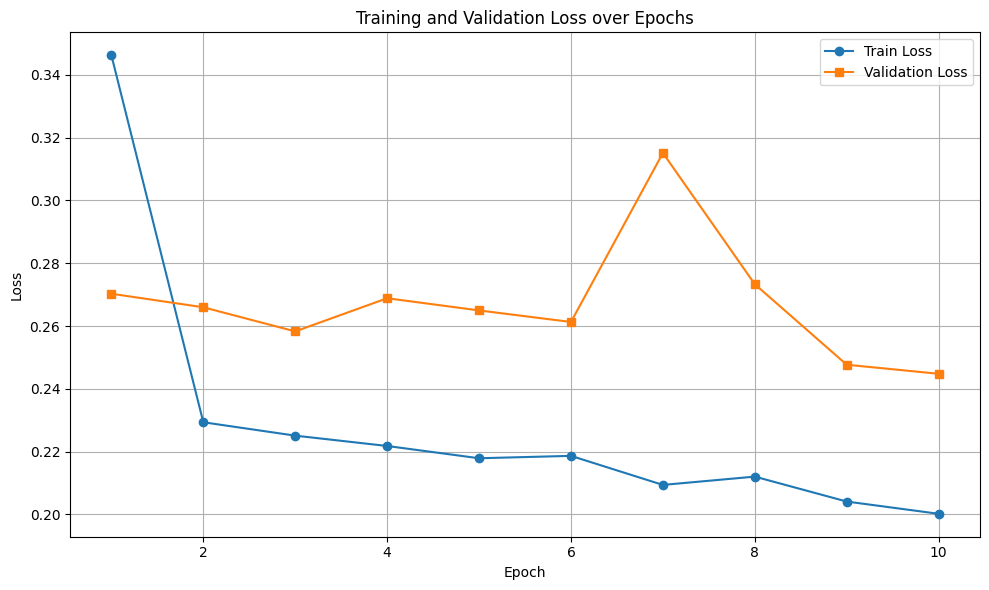

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='s')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
pred_list = []
actual_list = []
error_list = []

model.eval()

with torch.no_grad():
    for i in tqdm(range(len(val_loader.dataset))):

        x_sample = val_dataset[i][0].unsqueeze(0).to(device)
        y_true = val_dataset[i][1][0].cpu().numpy()

        y_pred_norm = model(x_sample).cpu().numpy()[0, 0]

        z_mean, z_std = 5880, 100


        pred_height = y_pred_norm * z_std + z_mean
        actual_height = y_true * z_std + z_mean
        abs_error = np.abs(pred_height - actual_height)

        pred_list.append(pred_height)
        actual_list.append(actual_height)
        error_list.append(abs_error)

100%|██████████| 66/66 [00:09<00:00,  7.24it/s]


In [19]:
file_path = '/content/drive/MyDrive/[2025-1]_리빙랩'

valid_time_file = os.path.join(file_path, 'valid_times_full_(z,t,u,v,q).npy')
val_time_raw = np.load(valid_time_file)

print(f"총 valid_time 수: {len(val_time_raw)}")

총 valid_time 수: 328


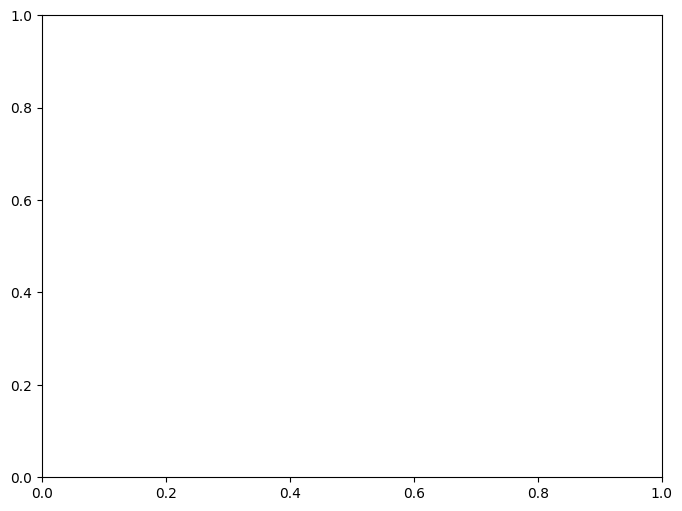

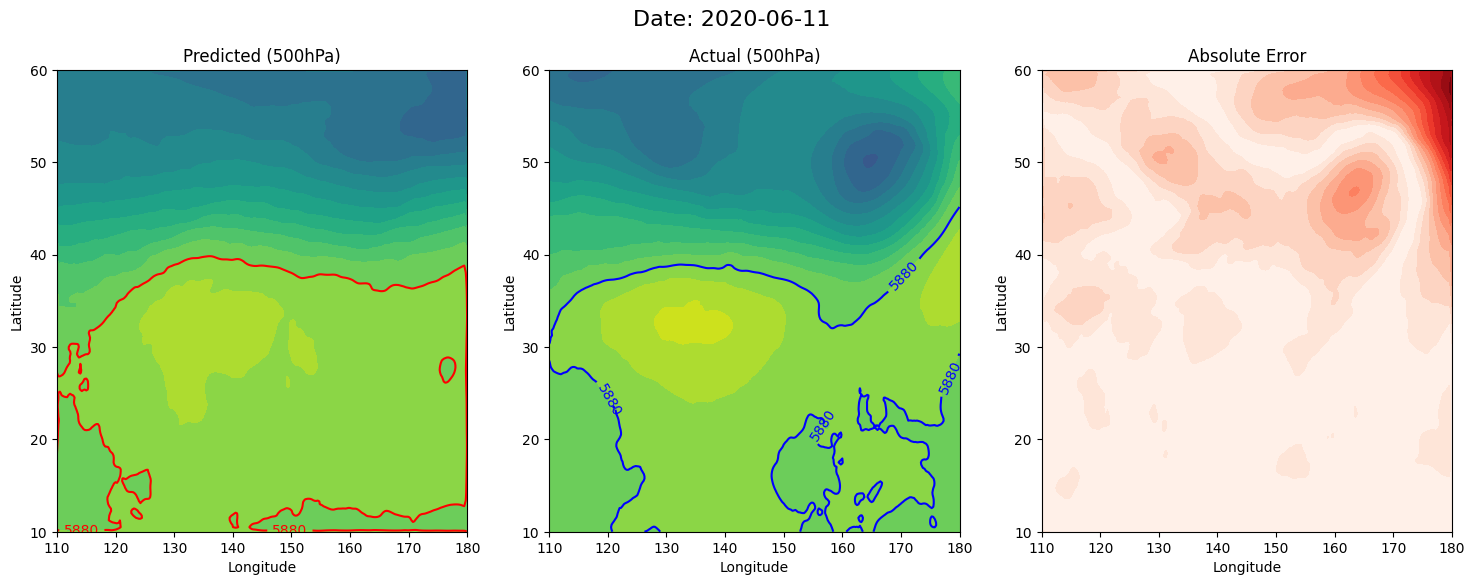

In [20]:
z = ds['z'].sel(pressure_level=500)
time = ds['valid_time'].values
lat = ds['latitude'].values
lon = ds['longitude'].values
z = z / 9.80665

fig, ax = plt.subplots(figsize=(8, 6))
lon2d, lat2d = np.meshgrid(lon, lat)

val_time = [pd.to_datetime(str(t)) for t in val_time_raw]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
levels = np.linspace(5400, 6000, 21)
contour_level = [5880]

def update(frame):
    for ax in axes:
        ax.clear()

    pred = pred_list[frame]
    actual = actual_list[frame]
    err = error_list[frame]


    cf0 = axes[0].contourf(lon2d, lat2d, pred, levels=levels, cmap='viridis')
    cl0 = axes[0].contour(lon2d, lat2d, pred, levels=contour_level, colors='red')
    axes[0].clabel(cl0, fmt={5880: '5880'}, colors='red')
    axes[0].set_title("Predicted (500hPa)")
    axes[0].set_xlabel("Longitude")
    axes[0].set_ylabel("Latitude")

    cf1 = axes[1].contourf(lon2d, lat2d, actual, levels=levels, cmap='viridis')
    cl1 = axes[1].contour(lon2d, lat2d, actual, levels=contour_level, colors='blue')
    axes[1].clabel(cl1, fmt={5880: '5880'}, colors='blue')
    axes[1].set_title("Actual (500hPa)")
    axes[1].set_xlabel("Longitude")
    axes[1].set_ylabel("Latitude")

    cf2 = axes[2].contourf(lon2d, lat2d, err, levels=20, cmap='Reds')
    axes[2].set_title("Absolute Error")
    axes[2].set_xlabel("Longitude")
    axes[2].set_ylabel("Latitude")

    fig.suptitle(f"Date: {val_time[frame].strftime('%Y-%m-%d')}", fontsize=16)

ani = animation.FuncAnimation(fig, update, frames=len(pred_list), interval=300, blit=False)


In [ ]:
gif_save_path = "yourpath/Conv3D('z','t','u','v','q'_예측_실제_오차_비교_지도스타일.gif"
ani.save(gif_save_path, writer='pillow', fps=3)

print("GIF 저장 완료:", gif_save_path)

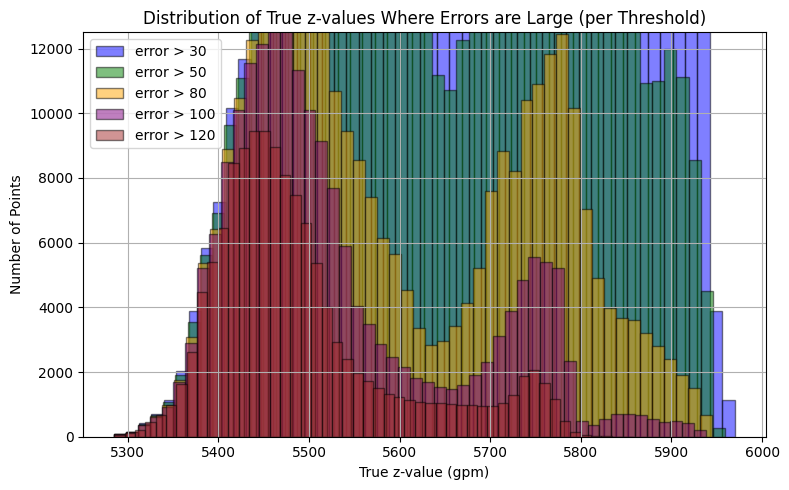

In [22]:
plt.rcParams['font.family'] = 'DejaVu Sans'

thresholds = [30,50,80,100,120]
z_distributions = {thr: [] for thr in thresholds}

for pred, actual in zip(pred_list, actual_list):
    error = np.abs(pred - actual)
    for thr in thresholds:
        mask = error > thr
        z_vals = actual[mask]
        z_distributions[thr].append(z_vals)

for thr in thresholds:
    z_distributions[thr] = np.concatenate(z_distributions[thr])

plt.figure(figsize=(8, 5))
colors = ['blue', 'green', 'orange', 'purple', 'brown', 'red']

for thr, color in zip(thresholds, colors):
    plt.hist(z_distributions[thr], bins=50, alpha=0.5,
             label=f'error > {thr}', color=color, edgecolor='black')

plt.title("Distribution of True z-values Where Errors are Large (per Threshold)")
plt.xlabel("True z-value (gpm)")
plt.ylabel("Number of Points")
plt.ylim(0,12500)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [23]:
!pip install shapely

pred_mask sum: 14085
actual_mask sum: 11540


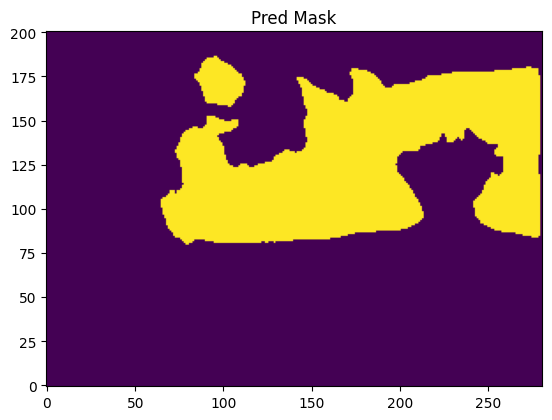

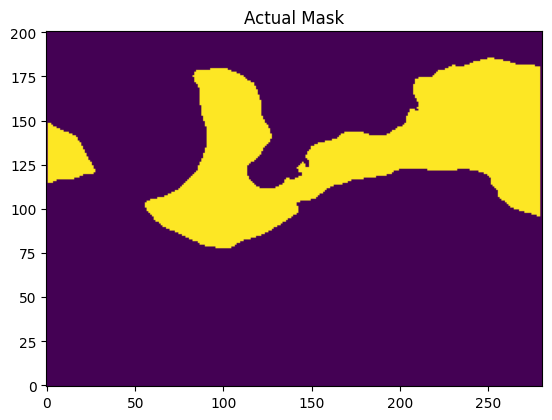

In [24]:
pred_contours = plt.contour(lon2d, lat2d, pred, levels=[5880])
actual_contours = plt.contour(lon2d, lat2d, actual, levels=[5880])

def create_mask_from_contours(contours, lon2d, lat2d):
    from matplotlib.path import Path

    mask = np.zeros_like(lon2d, dtype=bool)

    for seg in contours:
        path = Path(seg)
        points = np.vstack((lon2d.flatten(), lat2d.flatten())).T
        inside = path.contains_points(points).reshape(lon2d.shape)
        mask |= inside

    return mask

pred_mask = create_mask_from_contours(pred_contours.allsegs[0], lon2d, lat2d)
actual_mask = create_mask_from_contours(actual_contours.allsegs[0], lon2d, lat2d)

print("pred_mask sum:", pred_mask.sum())
print("actual_mask sum:", actual_mask.sum())

plt.imshow(pred_mask, origin='lower')
plt.title("Pred Mask")
plt.show()

plt.imshow(actual_mask, origin='lower')
plt.title("Actual Mask")
plt.show()


In [25]:
def calculate_iou(pred, actual, lon2d, lat2d, contour_level=5880):
    from matplotlib.path import Path

    pred_contours = plt.contour(lon2d, lat2d, pred, levels=[contour_level])
    actual_contours = plt.contour(lon2d, lat2d, actual, levels=[contour_level])
    plt.close()

    def create_mask_from_contours(contours, lon2d, lat2d):
        mask = np.zeros_like(lon2d, dtype=bool)
        for seg in contours:
            path = Path(seg)
            points = np.vstack((lon2d.flatten(), lat2d.flatten())).T
            inside = path.contains_points(points).reshape(lon2d.shape)
            mask |= inside
        return mask

    if len(pred_contours.allsegs[0]) == 0 or len(actual_contours.allsegs[0]) == 0:
        return 0.0

    pred_mask = create_mask_from_contours(pred_contours.allsegs[0], lon2d, lat2d)
    actual_mask = create_mask_from_contours(actual_contours.allsegs[0], lon2d, lat2d)

    intersection = np.logical_and(pred_mask, actual_mask).sum()
    union = np.logical_or(pred_mask, actual_mask).sum()

    if union == 0:
        return 0.0

    return intersection / union


In [26]:
iou_scores = []
val_time_plot = []

for frame in range(len(pred_list)):
    pred = pred_list[frame]
    actual = actual_list[frame]
    iou = calculate_iou(pred, actual, lon2d, lat2d, contour_level=5880)
    iou_scores.append(iou)
    val_time_plot.append(val_time[frame])


for t, iou in zip(val_time, iou_scores):
    print(f"{t.strftime('%Y-%m-%d')}: IOU = {iou:.4f}")


2020-06-11: IOU = 0.1686
2020-06-11: IOU = 0.4533
2020-06-11: IOU = 0.5240
2020-06-11: IOU = 0.4658
2020-06-12: IOU = 0.6349
2020-06-12: IOU = 0.4534
2020-06-12: IOU = 0.6566
2020-06-12: IOU = 0.5193
2020-06-13: IOU = 0.6688
2020-06-13: IOU = 0.3992
2020-06-13: IOU = 0.6531
2020-06-13: IOU = 0.4578
2020-06-14: IOU = 0.5575
2020-06-14: IOU = 0.4366
2020-06-14: IOU = 0.5511
2020-06-14: IOU = 0.5724
2020-06-15: IOU = 0.5598
2020-06-15: IOU = 0.2285
2020-06-15: IOU = 0.5572
2020-06-15: IOU = 0.4921
2020-06-16: IOU = 0.5612
2020-06-16: IOU = 0.4654
2020-06-16: IOU = 0.2037
2020-06-16: IOU = 0.2113
2020-06-17: IOU = 0.1413
2020-06-17: IOU = 0.3687
2020-06-17: IOU = 0.1738
2020-06-17: IOU = 0.3005
2020-06-18: IOU = 0.1393
2020-06-18: IOU = 0.2709
2020-06-18: IOU = 0.2119
2020-06-18: IOU = 0.1802
2020-06-19: IOU = 0.3297
2020-06-19: IOU = 0.1999
2020-06-19: IOU = 0.4187
2020-06-19: IOU = 0.4902
2020-06-20: IOU = 0.3597
2020-06-20: IOU = 0.4683
2020-06-20: IOU = 0.0839
2020-06-20: IOU = 0.4571


In [27]:
import numpy as np

valid_ious = [iou for iou in iou_scores if not np.isnan(iou)]

if valid_ious:
    mean_iou = np.mean(valid_ious)
    print(f"평균 IOU (NaN 제외): {mean_iou:.4f}")
else:
    print("유효한 IOU 값이 없습니다.")


평균 IOU (NaN 제외): 0.3701


In [ ]:
plt.savefig("yourpath/iou_timeseries_Conv3D_z_t_u_v_q.png", dpi=300)

<Figure size 640x480 with 0 Axes>

In [29]:
import matplotlib.dates as mdates

<ipython-input-30-1d122812092a>:15: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-30-1d122812092a>:15: UserWarning: Glyph 51456 (\N{HANGUL SYLLABLE JUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-30-1d122812092a>:15: UserWarning: Glyph 49440 (\N{HANGUL SYLLABLE SEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51456 (\N{HANGUL SYLLABLE JUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49440 (\N{HANGUL SYLLABLE SEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_

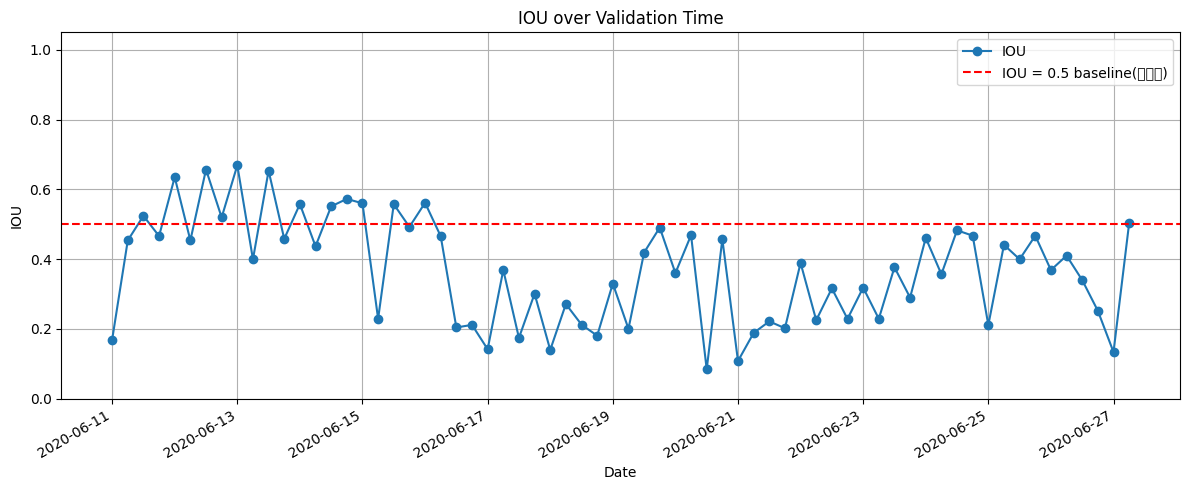

In [30]:
plt.figure(figsize=(12, 5))
plt.plot(val_time_plot, iou_scores, marker='o', linestyle='-', label='IOU')
plt.axhline(y=0.5, color='r', linestyle='--', label='IOU = 0.5 baseline(기준선)')

plt.title('IOU over Validation Time')
plt.xlabel('Date')
plt.ylabel('IOU')
plt.ylim(0, 1.05)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [31]:
plt.savefig("iou_timeseries_Conv3D('z','t','u','v','q').png", dpi=300)

<Figure size 640x480 with 0 Axes>

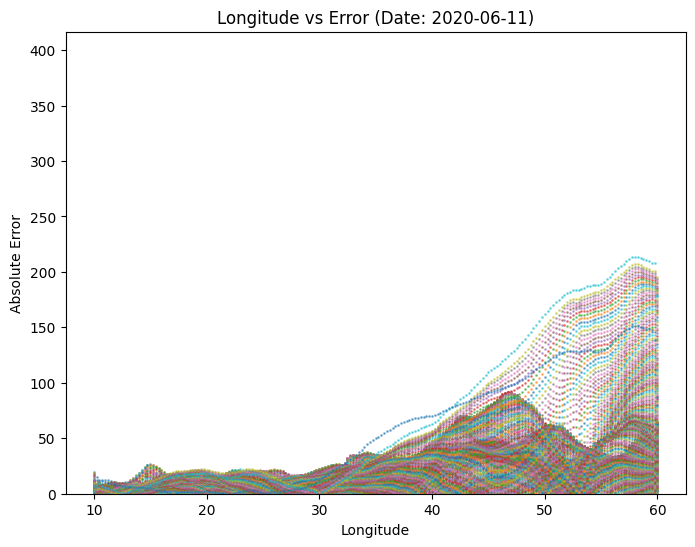

In [32]:
all_errors = np.stack(error_list)
ymin = all_errors.min()
ymax = all_errors.max()

fig_error, ax_error = plt.subplots(figsize=(8, 6))

def update(frame):
    for ax in axes:
        ax.clear()

    pred = pred_list[frame]
    actual = actual_list[frame]
    err = error_list[frame]

    cf0 = axes[0].contourf(lon2d, lat2d, pred, levels=levels, cmap='viridis')
    cl0 = axes[0].contour(lon2d, lat2d, pred, levels=contour_level, colors='red')
    axes[0].clabel(cl0, fmt={5880: '5880'}, colors='red')
    axes[0].set_title("Predicted (500hPa)")
    axes[0].set_xlabel("Longitude")
    axes[0].set_ylabel("Latitude")

    cf1 = axes[1].contourf(lon2d, lat2d, actual, levels=levels, cmap='viridis')
    cl1 = axes[1].contour(lon2d, lat2d, actual, levels=contour_level, colors='blue')
    axes[1].clabel(cl1, fmt={5880: '5880'}, colors='blue')
    axes[1].set_title("Actual (500hPa)")
    axes[1].set_xlabel("Longitude")
    axes[1].set_ylabel("Latitude")

    cf2 = axes[2].contourf(lon2d, lat2d, err, levels=20, cmap='Reds')
    axes[2].set_title("Absolute Error")
    axes[2].set_xlabel("Longitude")
    axes[2].set_ylabel("Latitude")

    ax_error.clear()
    ax_error.set_ylim(ymin, ymax)

    ax_error.set_title(f"Longitude vs Error (Date: {val_time[frame].strftime('%Y-%m-%d')})")
    ax_error.set_xlabel("Longitude")
    ax_error.set_ylabel("Absolute Error")

    for j in range(len(lon)):
         ax_error.plot(lat, err[:, j], '.', alpha=0.5, markersize=2)

    fig.suptitle(f"Date: {val_time[frame].strftime('%Y-%m-%d')}", fontsize=16)

ani_main = animation.FuncAnimation(fig, update, frames=len(pred_list), interval=300, blit=False)
ani_error = animation.FuncAnimation(fig_error, update, frames=len(pred_list), interval=300, blit=False)

In [ ]:
gif_save_path = "yourpath/Conv3D('z','t','u','v','q')산점도-경도.gif"
ani_error.save(gif_save_path, writer='pillow', fps=3)

print("GIF 저장 완료:", gif_save_path)